

Recurrent neural networks (**RNNs**), especially **LSTMs**, are powerful for modeling sequence data and time series. In this lab, you'll build a univariate time series predictor. (In HW2, you'll extend this to multivariate forecasting.)

What you'll do:

- Visualize and scale a classic daily minimum temperature dataset
- Convert the series into supervised sequences using a **sliding window**
- Train an **LSTM regressor** with `EarlyStopping`
- **Inverse-transform** predictions and compute **RMSE** on train/test sets
- Compare results against a **feed-forward (MLP)** baseline

> 💡 **Tip:** Training is much faster on a GPU or Apple Silicon (MPS), but CPU works too.

Let's get started!

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
import keras
import torch
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras.callbacks import EarlyStopping

In [37]:
# Detect operating system and set Keras backend
import platform
import os
system = platform.system()

if system == "Darwin":  # macOS
    os.environ["KERAS_BACKEND"] = "tensorflow"
    print("Detected macOS: Using TensorFlow backend")
else:  # Windows or Linux
    os.environ["KERAS_BACKEND"] = "torch"
    print(f"Detected {system}: Using PyTorch backend")

Detected macOS: Using TensorFlow backend


In [38]:
# Check and configure device (GPU/CPU)
def configure_device():
    backend = os.environ.get("KERAS_BACKEND", "tensorflow")

    if backend == "tensorflow":
        import tensorflow as tf
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            print(f"GPU available: {len(gpus)} GPU(s) detected")
            print(f"Using GPU: {gpus[0].name}")
            return "GPU"
        else:
            print("No GPU detected. Using CPU")
            return "CPU"

    elif backend == "torch":
        import torch
        if torch.cuda.is_available():
            device = torch.device("cuda")
            print(f"GPU available: {torch.cuda.get_device_name(0)}")
            print("Using GPU")
            return "GPU"
        else:
            print("No GPU detected. Using CPU")
            return "CPU"

device_type = configure_device()

GPU available: 1 GPU(s) detected
Using GPU: /physical_device:GPU:0


## Data Preprocessing

We start by loading the daily minimum temperature dataset, parsing the dates, and visualizing the overall trend. This helps us understand the time range and any patterns or anomalies in the data.

### Step 1 —  Load the dataset

In [39]:

# Load the data
TEMPERATURES_CSV = 'daily-min-temperatures.csv'
df = pd.read_csv(TEMPERATURES_CSV)
# Parse and sort dates if available
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)
print(f"Dataframe shape: {df.shape}")
if 'Date' in df.columns:
    print(f"Date range: {df['Date'].min().date()} → {df['Date'].max().date()}")

Dataframe shape: (3650, 2)
Date range: 1981-01-01 → 1990-12-31


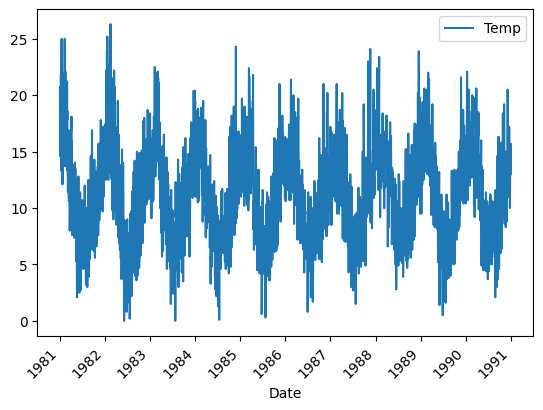

In [40]:
# plot the trend, use the date as the x-axis
df.plot(x='Date', y='Temp')
# x-axis labels rotate 45 degrees
plt.xticks(rotation=45)
plt.show()

This is a univariate time series prediction problem: we use past values of the temperature to predict future values. This approach leverages the temporal dependencies in the data.

### Step 2 — Reshape the univariate series into a 2-D feature array

In a univariate time-series, we have only one feature (e.g., temperature), so the raw data is a 1-D array.

However, deep learning models (such as LSTMs, GRUs, and MLPs) expect input data to be at least 2-D or 3-D tensors, not plain 1-D vectors.

Therefore, we reshape the series into a 2-D array with shape:

**(samples, features)** = **(N, 1)**

This prepares the data for sliding-window (sequence) creation and later reshaping to 3-D for LSTM input.


In [41]:
series = df['Temp'].values.astype(float).reshape(-1, 1)
print(f"Dataset shape: {series.shape}")

Dataset shape: (3650, 1)


### Step 3 — Chronological split: train+val vs test

You cannot use random way of splitting dataset into train and test as the sequence of events is important for time series.
we will take first 80% values for train and the remaining 20 for testing

In [42]:
#set the ratios for test and validation
TEST_RATIO = 0.125     # last 20% for test
VAL_RATIO  = 0.125   # last 12.5% of (train+val) for val (≈10% overall)

# Chronological split: train+val vs test
n_total = len(series)
n_test  = int(np.round(TEST_RATIO * n_total))
series_trainval = series[: n_total - n_test]   # no future leakage
series_test     = series[n_total - n_test :]

In [43]:
# Split train+val into train and val sets
n_trainval = len(series_trainval)
n_val_raw  = int(np.round(VAL_RATIO * n_trainval))
n_train_raw = n_trainval - n_val_raw

series_train_raw = series_trainval[:n_train_raw]
series_val_raw   = series_trainval[n_train_raw:]
series_test_raw  = series_test

### Step 4 - Feature Scaling

LSTMs are sensitive to the scale of input data. We normalize the series (e.g., to [0, 1]) before training to ensure stable and efficient learning.

**Note:**
- In production, always fit the scaler on the training set only to avoid data leakage. Here, for simplicity, we fit on the full series.

In [44]:
# Fit scaler ONLY on training raw values
scaler = MinMaxScaler()
scaler.fit(series_train_raw)

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [45]:
# Transform each split separately
train_scaled = scaler.transform(series_train_raw)
val_scaled   = scaler.transform(series_val_raw)
test_scaled  = scaler.transform(series_test_raw)


### Step 5 — Transform the Time Series into a Supervised Learning Format

To train a LSTM model on sequences, we convert the time series into **input–output pairs** using a sliding window.  
Each input window contains a fixed number of **past observations**, and the corresponding target is the **next value** in the series.

This turns our time-series data into a supervised learning problem suitable for LSTM

LSTM models require data in the format: (samples, time_steps, features)

<img src="https://www.mdpi.com/applsci/applsci-13-04644/article_deploy/html/images/applsci-13-04644-g002.png" alt="Sliding window example" width="600" height="400">


The function below generates these input/output sequences.


In [46]:

# helper function
def make_windows(series_2d, window=1):
    X, y = [], []
    for i in range(len(series_2d) - window):
        X.append(series_2d[i:i+window, :])   # (window, 1)
        y.append(series_2d[i+window, :])     # (1,)
    return np.array(X), np.array(y)

So after creating the sliding windows, we reshape the training and validation sets into this 3-D structure and print their shapes to confirm everything is aligned correctly.

In [47]:
WINDOW = 7  # days of historical data to use for prediction
# Build windows for each split independently (no cross-split mixing)
train_X, train_y = make_windows(train_scaled, WINDOW)
val_X,   val_y   = make_windows(val_scaled,   WINDOW)
test_X,  test_y  = make_windows(test_scaled,  WINDOW)

print(f"train_X: {train_X.shape}, train_y: {train_y.shape}")
print(f"val_X:   {val_X.shape},   val_y:   {val_y.shape}")
print(f"test_X:  {test_X.shape},  test_y:  {test_y.shape}")

train_X: (2788, 7, 1), train_y: (2788, 1)
val_X:   (392, 7, 1),   val_y:   (392, 1)
test_X:  (449, 7, 1),  test_y:  (449, 1)


The data is ready, let's build your models next!

## Time Series Forcasting

### Task 1: Build your LSTM Model for time series

Construct a simple LSTM model with two layers:

- LSTM layer with 50 units
- Dense output layer with 1 unit (for regression)

Use the Adam optimizer and mean squared error loss to compile the model.


In [48]:

# build the LSTM model
def create_LSTM_model():
    model = keras.models.Sequential([
        Input(shape=(WINDOW, 1)),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    return model
model = create_LSTM_model()

# compile the model
model.compile(optimizer='adam', loss='mse')

# display the model summary
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

### Task 2: Train Your LSTM with Early Stopping

Now train your LSTM model using the following configuration:

**Early Stopping Callback:**
- Monitor: `val_loss` (validation loss)
- Patience: `5` epochs (stop if no improvement for 5 consecutive epochs)
- Restore best weights: `True` (automatically load the weights from the epoch with the best validation loss)

**Training Configuration:**
- Training data: `train_X`, `train_y`
- Validation data: `val_X`, `val_y` (use the `validation_data` parameter)
- Epochs: `100` (maximum, but early stopping may end training sooner)
- Batch size: `32`
- Shuffle: `False` (important for time series to preserve temporal order)
- Verbose: `1` (display progress)
- Callbacks: `[early_stopping]`

**Why Early Stopping?**

Early stopping prevents overfitting by monitoring the validation loss. If the model stops improving on the validation set, training halts and the best weights are restored. This saves time and ensures you get the best-performing model without manual tuning.

The code below is already set up the structure for you

In [49]:
from keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                           restore_best_weights=True)

# Train the LSTM model with early stopping
lstm_history = model.fit(train_X, train_y,
            validation_data=(val_X, val_y),
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping],
            shuffle=False, 
            verbose=1)

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0432 - val_loss: 0.0119
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0111 - val_loss: 0.0108
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0110 - val_loss: 0.0106
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0108 - val_loss: 0.0105
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0107 - val_loss: 0.0104
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0106 - val_loss: 0.0103
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0105 - val_loss: 0.0101
Epoch 9/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0104 - val_loss: 0.0100
Epoch 10/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 11/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 12/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step

### Task 3: Plotting the training and validation loss below

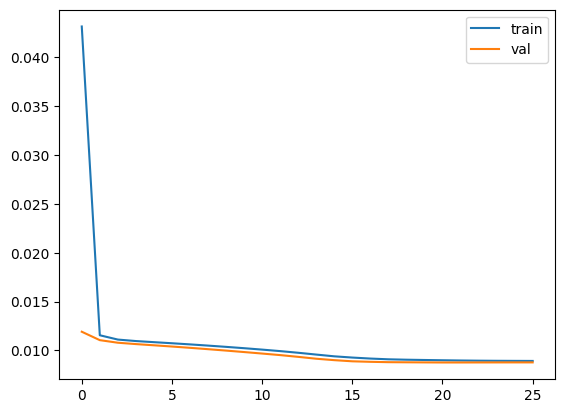

In [50]:
# plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(lstm_history.history['loss'], label='train')
plt.plot(lstm_history.history['val_loss'], label='val')
plt.legend()
plt.show()


In [51]:
import numpy as np

best_epoch = np.argmin(lstm_history.history['val_loss']) + 1  # +1 because epochs start at 1
best_val_loss = np.min(lstm_history.history['val_loss'])

print(f"Best epoch: {best_epoch}")
print(f"Lowest validation loss: {best_val_loss:.4f}")


Best epoch: 21
Lowest validation loss: 0.0088


### Task 4: Generate Predictions and Evaluate Performance

Now that your LSTM model is trained, it's time to:

1. **Generate predictions** on all three datasets (train, validation, test)
2. **Inverse-transform** the predictions back to the original temperature scale
3. **Compute evaluation metrics** (RMSE and MAE) to assess model performance

**What you need to do:**

**Step 1: Generate Predictions (Scaled)**
- Use `lstm_model.predict()` to generate predictions for `train_X`, `val_X`, and `test_X`
- Store the results in `train_pred`, `val_pred`, and `test_pred`

**Step 2: Inverse-Transform to Original Scale**
- Remember: Your data was normalized using `MinMaxScaler`
- Use `scaler.inverse_transform()` to convert predictions back to original temperature units
- Also inverse-transform the actual target values (`train_y`, `val_y`, `test_y`)
- Store the inverse-transformed predictions in `train_pred_inv`, `val_pred_inv`, `test_pred_inv`
- Store the inverse-transformed targets in `train_y_inv`, `val_y_inv`, `test_y_inv`

**Step 3: Calculate Performance Metrics**
- Compute **RMSE** (Root Mean Squared Error) using `root_mean_squared_error()`
- Compute **MAE** (Mean Absolute Error) using `mean_absolute_error()`
- Print the metrics for all three datasets (train, validation, test)

**Why inverse-transform?**
- Predictions are in the [0, 1] normalized range
- Inverse-transforming converts them back to degrees Celsius
- This makes the error metrics interpretable (e.g., RMSE of 2.5°C is meaningful)


The code structure is provided below — complete the missing parts!
Please use the **same variable names** shown in the next section so your predictions can be visualized correctly.

In [52]:

# Making prediction
train_pred = model.predict(train_X)
val_pred = model.predict(val_X)
test_pred = model.predict(test_X)

# Inverse-transform back to original units
train_pred_inv = scaler.inverse_transform(train_pred)
test_pred_inv = scaler.inverse_transform(test_pred)
val_pred_inv = scaler.inverse_transform(val_pred)

train_y_inv = scaler.inverse_transform(train_y)
val_y_inv = scaler.inverse_transform(val_y)
test_y_inv = scaler.inverse_transform(test_y)

# Evaluate the model performance
print('Train RMSE, MAE Performance:', root_mean_squared_error(train_y_inv, train_pred_inv), mean_absolute_error(train_y_inv, train_pred_inv))
print('Val RMSE, MAE Performance:', root_mean_squared_error(val_y_inv, val_pred_inv), mean_absolute_error(val_y_inv, val_pred_inv))
print('Test RMSE, MAE Performance:', root_mean_squared_error(test_y_inv, test_pred_inv), mean_absolute_error(test_y_inv, test_pred_inv))


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Train RMSE, MAE Performance: 2.4669550078223152 1.92856011390686
Val RMSE, MAE Performance: 2.4613805468532335 1.962479340056984
Test RMSE, MAE Performance: 2.2989339750702267 1.7806727128995288


**Expected output:**
```
Train RMSE: X.XXX,  MAE: X.XXX
Val   RMSE: X.XXX,  MAE: X.XXX
Test  RMSE: X.XXX,  MAE: X.XXX
```

### Visualize Predictions

We plot the original data along with the model's predictions for both the training and test sets. This visualization helps us see how closely the model tracks the actual temperature values.

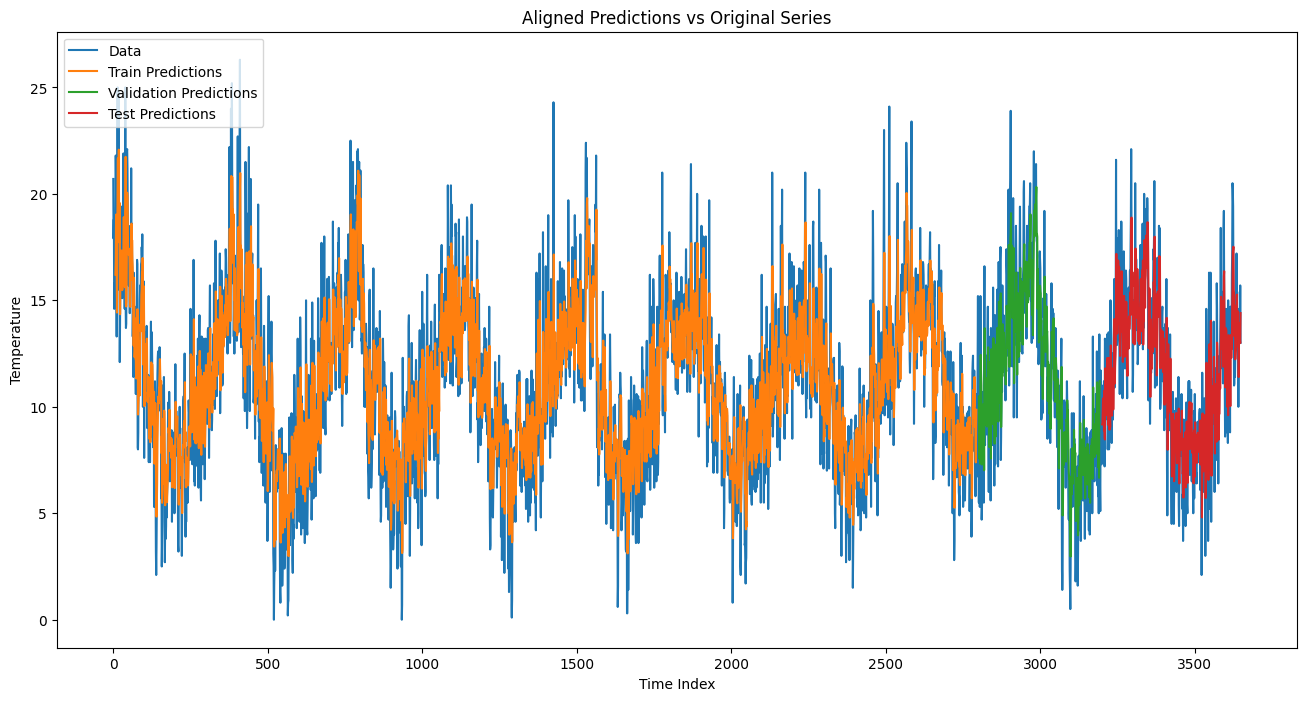

In [53]:
T = len(series)

# Containers for aligned predictions (original units)
train_pred_plot = np.full((T, 1), np.nan, dtype=float)
val_pred_plot   = np.full((T, 1), np.nan, dtype=float)
test_pred_plot  = np.full((T, 1), np.nan, dtype=float)

# --- Train segment ---
# train windows start at indices [0 .. n_train_raw-1] -> first pred aligns at index WINDOW
train_start_idx = WINDOW
train_end_idx   = train_start_idx + len(train_pred_inv)
train_end_idx   = min(train_end_idx, n_train_raw)  # safety clip
train_pred_plot[train_start_idx:train_end_idx, 0] = train_pred_inv[:(train_end_idx - train_start_idx), 0]

# --- Validation segment ---
# val segment starts at n_train_raw; first val pred aligns at n_train_raw + WINDOW
val_seg_start   = n_train_raw
val_start_idx   = val_seg_start + WINDOW
val_end_idx     = val_start_idx + len(val_pred_inv)
val_end_idx     = min(val_end_idx, n_trainval)  # validation ends at n_trainval
val_pred_plot[val_start_idx:val_end_idx, 0] = val_pred_inv[:(val_end_idx - val_start_idx), 0]

# --- Test segment ---
# test segment starts at n_trainval; first test pred aligns at n_trainval + WINDOW
test_seg_start  = n_trainval
test_start_idx  = test_seg_start + WINDOW
test_end_idx    = test_start_idx + len(test_pred_inv)
test_end_idx    = min(test_end_idx, T)  # clip to total length
test_pred_plot[test_start_idx:test_end_idx, 0] = test_pred_inv[:(test_end_idx - test_start_idx), 0]

# --- Plot ---
plt.figure(figsize=(16, 8))
plt.plot(series, label='Data')  # already in original units
plt.plot(train_pred_plot, label='Train Predictions')
plt.plot(val_pred_plot,   label='Validation Predictions')
plt.plot(test_pred_plot,  label='Test Predictions')
plt.legend(loc='upper left')
plt.title('Aligned Predictions vs Original Series')
plt.xlabel('Time Index')
plt.ylabel('Temperature')
plt.show()


### Feed-Forward Neural Network (MLP) for Time Series

Feed-forward neural networks (MLPs) can also be used for time series forecasting by flattening the input sequences. While they do not capture temporal dependencies as effectively as LSTMs, they are simple and efficient for many tasks.

![](images/mlp_ts.png)

### Task 5: Data Preprocessing for MLP

For MLPs, we flatten each input sequence so that each sample is a single vector. This allows the feed-forward network to process the data.

In [54]:
# Flatten sliding window for MLP:
# (samples, timesteps, features) -> (samples, timesteps*features)
# Flatten sliding windows
train_X_mlp = train_X.reshape((train_X.shape[0], train_X.shape[1] * train_X.shape[2]))
val_X_mlp   = val_X.reshape((val_X.shape[0], val_X.shape[1] * val_X.shape[2]))
test_X_mlp  = test_X.reshape((test_X.shape[0], test_X.shape[1] * test_X.shape[2]))

print("MLP shapes:", train_X_mlp.shape, val_X_mlp.shape, test_X_mlp.shape)

MLP shapes: (2788, 7) (392, 7) (449, 7)


### Task 6: Build the MLP Model

Now let's build a **feed-forward neural network (MLP)** to compare against the LSTM's performance.

**Your Task:**
Construct a simple MLP with the following architecture:

**Model Structure:**
1. **Input Layer:**
   - Use `Input(shape=...)` to define the input

2. **First Hidden Layer:**
   - 100 units (neurons)
   - Activation function: `'relu'` (Rectified Linear Unit)

3. **Second Hidden Layer:**
   - 32 units
   - Activation function: `'relu'`

4. **Output Layer:**
   - 1 unit (single temperature value prediction)
   - No activation (linear activation for regression)

**Compilation:**
- Optimizer: `'adam'`
- Loss function: `'mse'` (mean squared error, same as LSTM)


The code structure is already provided below — just fill in

In [55]:
# --- Build MLP ---
def create_MLP_model(input_dim):
    model = keras.models.Sequential([
        Input(shape=(input_dim,)),
        Dense(100, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    return model

mlp_model = create_MLP_model(train_X_mlp.shape[1])
# Compile the MLP model
mlp_model.compile(optimizer='adam', loss='mse')

# model summary
mlp_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 100)            │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,065 (15.88 KB)

 Trainable params: 4,065 (15.88 KB)

 Non-trainable params: 0 (0.00 B)

### Task 7: Train, Evaluate, and Visualize the MLP

Train your MLP with the same setup as the LSTM, make predictions, report RMSE/MAE, and visualize your results.

In [56]:
# --- Train MLP ---
mlp_history = mlp_model.fit(train_X_mlp, train_y,
          validation_data=(val_X_mlp, val_y),
          epochs=100,
          batch_size=32,
          callbacks=[early_stopping],
          shuffle=False, 
          verbose=1)

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0406 - val_loss: 0.0105
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0106 - val_loss: 0.0093
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0094 - val_loss: 0.0089
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0092 - val_loss: 0.0088
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0091 - val_loss: 0.0088


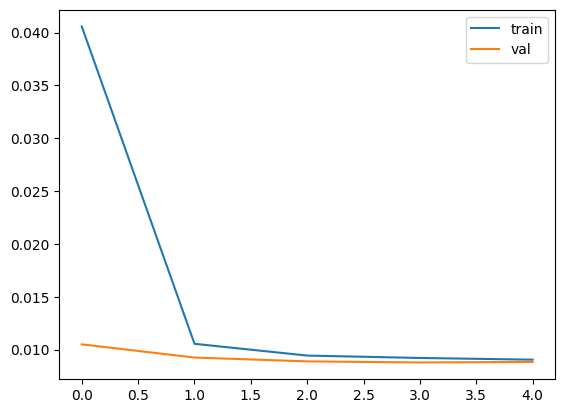

In [57]:
# plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(mlp_history.history['loss'], label='train')
plt.plot(mlp_history.history['val_loss'], label='val')
plt.legend()
plt.show()


In [58]:
import numpy as np

best_epoch = np.argmin(mlp_history.history['val_loss']) + 1  # +1 because epochs start at 1
best_val_loss = np.min(mlp_history.history['val_loss'])

print(f"Best epoch: {best_epoch}")
print(f"Lowest validation loss: {best_val_loss:.4f}")


Best epoch: 4
Lowest validation loss: 0.0088


In [59]:
# --- Predictions ---
# Making prediction
train_pred = mlp_model.predict(train_X_mlp)
val_pred = mlp_model.predict(val_X_mlp)
test_pred = mlp_model.predict(test_X_mlp)

# Inverse-transform back to original units
train_pred_inv = scaler.inverse_transform(train_pred)
test_pred_inv = scaler.inverse_transform(test_pred)
val_pred_inv = scaler.inverse_transform(val_pred)

train_y_inv = scaler.inverse_transform(train_y)
val_y_inv = scaler.inverse_transform(val_y)
test_y_inv = scaler.inverse_transform(test_y)

# Evaluate the model performance
print('Train RMSE, MAE Performance:', root_mean_squared_error(train_y_inv, train_pred_inv), mean_absolute_error(train_y_inv, train_pred_inv))
print('Val RMSE, MAE Performance:', root_mean_squared_error(val_y_inv, val_pred_inv), mean_absolute_error(val_y_inv, val_pred_inv))
print('Test RMSE, MAE Performance:', root_mean_squared_error(test_y_inv, test_pred_inv), mean_absolute_error(test_y_inv, test_pred_inv))

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train RMSE, MAE Performance: 2.729010908756829 2.1339681080458326
Val RMSE, MAE Performance: 2.6952636750862182 2.1250483919163137
Test RMSE, MAE Performance: 2.5567320924657237 2.004130255140547
